In [1]:
import mne

import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler

from IPython.display import clear_output
import os

import scipy
from scipy import io

In [2]:
data_path = 'AMIGOS/preprocessed/'

#### USE only Experiment1 (16 short videos) and preprocessed data

joined_data{1,YY} |||| XX x 17 |||| samples (depends on the duration of the video) x channels for trial YY


labels_selfassessment{1,YY}	|||| 1 x 12 |||| 1 x label (arousal, valence, dominance, liking, familiarity, neutral, disgust,happiness, surprise, anger, fear, and sadness) for trial YY

labels_ext_anotation{1,YY} |||| ZZ x 3 |||| segments (20 second clips) x channels (segment_index, valence and arousal) for trial YY

In [3]:
ext_annot = pd.read_excel(data_path + 'External_Annotations.xlsx')
videos_annot = ext_annot.drop(['UserID', 'VideoID'], axis=1)\
                .merge(pd.read_excel(data_path + 'Video_List.xlsx')[['Video_Number', 'Category']], 
                       on='Video_Number')

users_big5 = pd.read_excel(data_path + 'Participants_Personality.xlsx', 
                           sheet_name='Personalities').T.reset_index()
users_big5.columns = users_big5.iloc[0]
users_big5 = users_big5[1:]

In [4]:
df = pd.DataFrame({'UserID': [], 'Video_Number': [], 'EEG': [], 'Video_Rating': []})

for f in sorted([data_path + x for x in os.listdir(data_path) if 'Data_Preprocessed_P' in x]):
    UserID = f.split('_')[-1].split('.')[0].replace('P', '')
    
    data = io.loadmat(f)
    eegs = data['joined_data'][0].tolist()
    video_ratings = data['labels_selfassessment'][0].tolist()
    
    df0 = pd.DataFrame({'UserID': len(video_ratings)* [int(UserID)], 
                        'Video_Number': list(range(1,len(video_ratings) + 1)), 
                        'EEG': eegs, 'Video_Rating': video_ratings})
    
    df = pd.concat([df, df0], axis=0)
    
df = df.reset_index(drop=True)
df.UserID = df.UserID.astype(int)
df.Video_Number = df.Video_Number.astype(int)
df = df.merge(videos_annot[['Video_Number', 'Category']].drop_duplicates().rename({'Category':'Video_category'}, axis=1), 
              on='Video_Number')

kkkl = ['arousal', 'valence', 'dominance', 'liking', 'familiarity', 'neutral', 'disgust', 'happiness', 'surprise', 'anger', 'fear', 'sadness']
for i in range(len(kkkl)):
    df['Video_' + kkkl[i]] = [x[0][i] if x[0].shape[0] == 12 else None for x in df.Video_Rating]

df.drop('Video_Rating', axis=1, inplace=True)

del kkkl

df = df.merge(users_big5, on='UserID')
df = df[df.Video_Number < 17].reset_index(drop=True)

In [5]:
df.EEG = df.EEG.apply(lambda x: x[384:, :14])

In [6]:
df = df[[not bool(x[np.isnan(x)].shape[0]) for x in df.EEG]]

In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
def make_mne_eeg(eegmat):
    scaler = MinMaxScaler()
    eegmat = scaler.fit_transform(eegmat.T).T * 10e-5

    sampling_freq = 128  # in Hertz
    info = mne.create_info(['AF3', 'F7', 'F3', 'FC5', 'T7', 
                            'P7', 'O1', 'O2', 'P8', 'T8', 
                            'FC6', 'F4', 'F8', 'AF4'], sfreq=sampling_freq, 
                          ch_types= 14*['eeg'])

    raw = mne.io.RawArray(eegmat.T, info)
    raw.set_montage('standard_1020')
    raw.filter(0,30)
    
    return raw

def ica_correction(eegmat):
    scaler = MinMaxScaler()
    eegmat = scaler.fit_transform(eegmat.T).T * 10e-5

    sampling_freq = 128  # in Hertz
    info = mne.create_info(['AF3', 'F7', 'F3', 'FC5', 'T7', 
                            'P7', 'O1', 'O2', 'P8', 'T8', 
                            'FC6', 'F4', 'F8', 'AF4'], sfreq=sampling_freq, 
                          ch_types= 14*['eeg'])

    raw = mne.io.RawArray(eegmat.T, info)
    raw.set_montage('standard_1020')
    raw_tmp = raw.copy()
    
    raw_tmp.filter(1, None)  # high-pass filtration for ICA algo
        
    ica = mne.preprocessing.ICA(method="infomax", fit_params= {"extended": True})
    
    ica.fit(raw_tmp)
    ica.plot_components()
    ica.plot_sources(raw, start=15, stop=30)
    
    raw_corrected = raw.copy()
    channel_exclude=list(map(int, input("Input the channel index you want to exclude: ").split()))

    ica.exclude = channel_exclude
    ica.apply(raw_corrected)
    
    return scaler.fit_transform(raw_corrected[:][0]) * 10e-5

In [9]:
ica_processed_eegs = []

In [10]:
def scale_eeg(eegmat):
    scaler = MinMaxScaler()
    eegmat = scaler.fit_transform(eegmat.T) * 10e-5
    
    sampling_freq = 128  # in Hertz
    info = mne.create_info(['AF3', 'F7', 'F3', 'FC5', 'T7', 
                            'P7', 'O1', 'O2', 'P8', 'T8', 
                            'FC6', 'F4', 'F8', 'AF4'], sfreq=sampling_freq, 
                          ch_types= 14*['eeg'])

    raw = mne.io.RawArray(eegmat, info)
    raw.set_montage('standard_1020')

    raw.filter(1, 50) 
    return raw.get_data()

In [1]:
df.EEG = df.EEG.apply(scale_eeg)

==========0==========
Creating RawArray with float64 data, n_channels=14, n_times=11841
    Range : 0 ... 11840 =      0.000 ...    92.500 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 14 components
Computing Extended Infomax ICA
Fitting ICA took 2.1s.


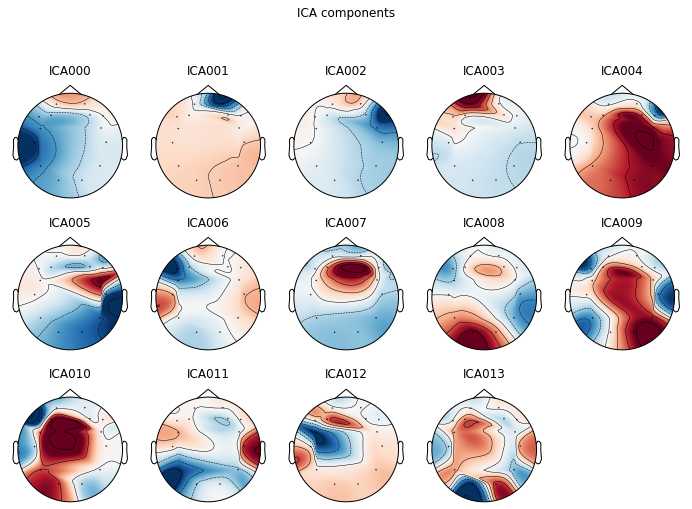

Creating RawArray with float64 data, n_channels=14, n_times=11841
    Range : 0 ... 11840 =      0.000 ...    92.500 secs
Ready.
Using matplotlib as 2D backend.


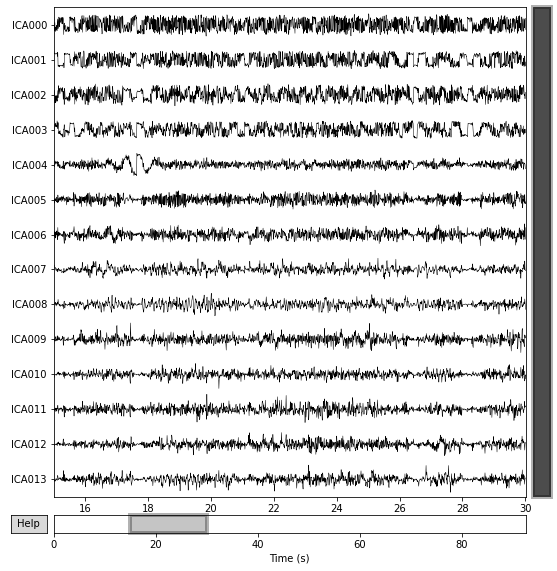

KeyboardInterrupt: Interrupted by user

In [10]:
for i in range(len(df.EEG.tolist())):
    if i < len(ica_processed_eegs):
        continue
        
    print('='*25)
    print('='*10 + str(i) + '='*10)
    print('='*25)
    
    eegmat = df.EEG[i]
    
    new_eegmat = ica_correction(eegmat)
    ica_processed_eegs.append(new_eegmat)
    
    clear_output(wait=True)

In [ ]:
df.EEG = pd.Series(ica_processed_eegs)

In [ ]:
# save progress
with open('ica_processing_all_done.pkl', 'wb') as f:
    pickle.dump(ica_processed_eegs, f)